In [1]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
print(BASE_DIR)

import numpy as np
import pandas as pd

import bokeh.plotting as bp
from bokeh.models import tools as bmt, ColumnDataSource

from bokeh.io import output_notebook, export_png
output_notebook()

from IPython.display import Image

/Users/biplovbhandari/UAH/Fall_2021/ESS_690_Hydrology/ess-690-hydrology


Loading BokehJS ...

In [2]:
BASE_DIR = f'{BASE_DIR}/HW#4'
BASE_DIR

'/Users/biplovbhandari/UAH/Fall_2021/ESS_690_Hydrology/ess-690-hydrology/HW#4'

In [3]:
def initialize_fig(title: str = 'your_title',
                   x_axis_label: str = 'x_axis_label',
                   x_axis_type: str = 'auto',
                   y_axis_label: str = 'y_axis_label',
                   y_axis_type: str = 'auto',
                   tools: str = 'pan,wheel_zoom,box_zoom,reset',
                   tooltips: list = [],
                   formatters: dict = {},
                   plot_height: int = 300,
                   fig_sizing_mode: str = 'scale_width',
                   ) -> bp.figure:
    # bokeh style
    TOOLS = tools
    hover_tool = bmt.HoverTool(tooltips=tooltips, formatters=formatters)

    fig = bp.figure(title=title,
                    x_axis_label=x_axis_label,
                    x_axis_type=x_axis_type,
                    y_axis_label=y_axis_label,
                    y_axis_type=y_axis_type,
                    plot_height=plot_height,
                    tools=TOOLS,
                   )
    fig.add_tools(hover_tool)
    fig.sizing_mode = fig_sizing_mode

    return fig

### Question 1

#### The 25 year, 24hour storm in a given watershed is 4 inches. The watershed area is 150 acres and is mostly agricultural, with 100 acres that are well cultivated (straight row) crops and in soil group D and 50 acres of wooded Forest with a soil group C.   Determine the depth and volume of runoff. Assume that the antecedent moisture conditions are wet.

In [4]:
area = 150. # acres
# from table 10.11 and 10.12
# agriculture with good straight row
# for amc II
soil_d_cn = 89.
# converting to amc III from table 10.12
soil_d_cn = 94. + (96-94) / (90-85) * 4.
print(f'soil_d_cn: {soil_d_cn}')

soil_d_area = 100.

# wooded forest
# for amc II
soil_c_cn = 72.
# converting to amc III from table 10.12
soil_c_cn = 85. + (88-85) / (75-70) * 2.
print(f'soil_c_cn: {soil_c_cn}')

soil_c_area = 50.

composite_cn = soil_c_area / area * soil_c_cn + soil_d_area / area * soil_d_cn
composite_cn

soil_d_cn: 95.6
soil_c_cn: 86.2


92.46666666666667

In [5]:
# storage
S = 1000 / composite_cn - 10
S # inches

0.814708002883922

In [6]:
# rainfall
P = 4. # inches
Q = ((P - 0.2 * S)**2) / (P + 0.8 * S)
Q # inches

3.165037941991686

In [7]:
# volume of streamflow runoff
Q_vol = area * Q # acres-inches
Q_vol

474.7556912987529

### Question 2

#### Given the following excess rainfall hyetograph and 1-hr unit hydrograph, derive the storm hydrograph for the watershed using the hydrograph convolution method. Assume no losses to infiltration or evapotranspiration 

#### Pn (intervals of 1 hr) = [0.2, 0.4 ,0.5 ,0.2 ,0 ,0.1] in
#### UH (intervals of 1 hr) = [0, 100, 320, 450, 370, 250, 160, 90, 40, 0] cfs 


In [8]:
Pn = np.array([ 0.2, 0.4, 0.5, 0.2, 0., 0.1 ]) # inches

# filling up with np.nan that would be used later
UH = [0., 100., 320., 450., 370., 250., 160., 90., 40., 0.] # cfs
UH_nan = [np.nan for _ in range(len(Pn)-1)]
UH = np.array(UH + UH_nan)

hr = np.arange(1., len(Pn)+1)

# Pn.resize(UH.shape)
expand_by = len(UH) - len(Pn)
Pn = np.pad(Pn, ((0, expand_by)), mode='constant', constant_values=np.nan)
hr = np.pad(hr, ((0, expand_by)), mode='constant', constant_values=np.nan)
Pn

array([0.2, 0.4, 0.5, 0.2, 0. , 0.1, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [9]:
df = pd.DataFrame({'UH': UH, 'Pn': Pn, 'hr': hr})
df

,UH,Pn,hr
0,0.0,0.2,1.0
1,100.0,0.4,2.0
2,320.0,0.5,3.0
3,450.0,0.2,4.0
4,370.0,0.0,5.0
5,250.0,0.1,6.0
6,160.0,NaN,NaN
7,90.0,NaN,NaN
8,40.0,NaN,NaN
9,0.0,NaN,NaN


In [10]:
df['P1Un'] = Pn[0] * df.UH
df

,UH,Pn,hr,P1Un
0,0.0,0.2,1.0,0.0
1,100.0,0.4,2.0,20.0
2,320.0,0.5,3.0,64.0
3,450.0,0.2,4.0,90.0
4,370.0,0.0,5.0,74.0
5,250.0,0.1,6.0,50.0
6,160.0,NaN,NaN,32.0
7,90.0,NaN,NaN,18.0
8,40.0,NaN,NaN,8.0
9,0.0,NaN,NaN,0.0


In [11]:
P2Un = np.array(Pn[1] * df.UH)
P2Un = [np.nan] + list(P2Un)
P2Un = P2Un[:-1]

In [12]:
df['P2Un'] = P2Un
df

,UH,Pn,hr,P1Un,P2Un
0,0.0,0.2,1.0,0.0,NaN
1,100.0,0.4,2.0,20.0,0.0
2,320.0,0.5,3.0,64.0,40.0
3,450.0,0.2,4.0,90.0,128.0
4,370.0,0.0,5.0,74.0,180.0
5,250.0,0.1,6.0,50.0,148.0
6,160.0,NaN,NaN,32.0,100.0
7,90.0,NaN,NaN,18.0,64.0
8,40.0,NaN,NaN,8.0,36.0
9,0.0,NaN,NaN,0.0,16.0


In [13]:
P3Un = np.array(Pn[2] * df.UH)
P3Un = [np.nan, np.nan] + list(P3Un)
P3Un = P3Un[:-2]

In [14]:
df['P3Un'] = P3Un
df

,UH,Pn,hr,P1Un,P2Un,P3Un
0,0.0,0.2,1.0,0.0,NaN,NaN
1,100.0,0.4,2.0,20.0,0.0,NaN
2,320.0,0.5,3.0,64.0,40.0,0.0
3,450.0,0.2,4.0,90.0,128.0,50.0
4,370.0,0.0,5.0,74.0,180.0,160.0
5,250.0,0.1,6.0,50.0,148.0,225.0
6,160.0,NaN,NaN,32.0,100.0,185.0
7,90.0,NaN,NaN,18.0,64.0,125.0
8,40.0,NaN,NaN,8.0,36.0,80.0
9,0.0,NaN,NaN,0.0,16.0,45.0


In [15]:
P4Un = np.array(Pn[3] * df.UH)
P4Un = [np.nan, np.nan, np.nan] + list(P4Un)
P4Un = P4Un[:-3]

In [16]:
df['P4Un'] = P4Un
df

,UH,Pn,hr,P1Un,P2Un,P3Un,P4Un
0,0.0,0.2,1.0,0.0,NaN,NaN,NaN
1,100.0,0.4,2.0,20.0,0.0,NaN,NaN
2,320.0,0.5,3.0,64.0,40.0,0.0,NaN
3,450.0,0.2,4.0,90.0,128.0,50.0,0.0
4,370.0,0.0,5.0,74.0,180.0,160.0,20.0
5,250.0,0.1,6.0,50.0,148.0,225.0,64.0
6,160.0,NaN,NaN,32.0,100.0,185.0,90.0
7,90.0,NaN,NaN,18.0,64.0,125.0,74.0
8,40.0,NaN,NaN,8.0,36.0,80.0,50.0
9,0.0,NaN,NaN,0.0,16.0,45.0,32.0


In [17]:
P5Un = np.array(Pn[4] * df.UH)
P5Un = [np.nan, np.nan, np.nan, np.nan] + list(P5Un)
P5Un = P5Un[:-4]

In [18]:
df['P5Un'] = P5Un
df

,UH,Pn,hr,P1Un,P2Un,P3Un,P4Un,P5Un
0,0.0,0.2,1.0,0.0,NaN,NaN,NaN,NaN
1,100.0,0.4,2.0,20.0,0.0,NaN,NaN,NaN
2,320.0,0.5,3.0,64.0,40.0,0.0,NaN,NaN
3,450.0,0.2,4.0,90.0,128.0,50.0,0.0,NaN
4,370.0,0.0,5.0,74.0,180.0,160.0,20.0,0.0
5,250.0,0.1,6.0,50.0,148.0,225.0,64.0,0.0
6,160.0,NaN,NaN,32.0,100.0,185.0,90.0,0.0
7,90.0,NaN,NaN,18.0,64.0,125.0,74.0,0.0
8,40.0,NaN,NaN,8.0,36.0,80.0,50.0,0.0
9,0.0,NaN,NaN,0.0,16.0,45.0,32.0,0.0


In [19]:
P6Un = np.array(Pn[5] * df.UH)
P6Un = [np.nan, np.nan, np.nan, np.nan, np.nan] + list(P6Un)
P6Un = P6Un[:-5]

In [20]:
df['P6Un'] = P6Un
df

,UH,Pn,hr,P1Un,P2Un,P3Un,P4Un,P5Un,P6Un
0,0.0,0.2,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,100.0,0.4,2.0,20.0,0.0,NaN,NaN,NaN,NaN
2,320.0,0.5,3.0,64.0,40.0,0.0,NaN,NaN,NaN
3,450.0,0.2,4.0,90.0,128.0,50.0,0.0,NaN,NaN
4,370.0,0.0,5.0,74.0,180.0,160.0,20.0,0.0,NaN
5,250.0,0.1,6.0,50.0,148.0,225.0,64.0,0.0,0.0
6,160.0,NaN,NaN,32.0,100.0,185.0,90.0,0.0,10.0
7,90.0,NaN,NaN,18.0,64.0,125.0,74.0,0.0,32.0
8,40.0,NaN,NaN,8.0,36.0,80.0,50.0,0.0,45.0
9,0.0,NaN,NaN,0.0,16.0,45.0,32.0,0.0,37.0


In [21]:
df['Qn'] = df[['P1Un', 'P2Un', 'P3Un', 'P4Un', 'P5Un', 'P6Un']].sum(axis=1)
df

,UH,Pn,hr,P1Un,P2Un,P3Un,P4Un,P5Un,P6Un,Qn
0,0.0,0.2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
1,100.0,0.4,2.0,20.0,0.0,NaN,NaN,NaN,NaN,20.0
2,320.0,0.5,3.0,64.0,40.0,0.0,NaN,NaN,NaN,104.0
3,450.0,0.2,4.0,90.0,128.0,50.0,0.0,NaN,NaN,268.0
4,370.0,0.0,5.0,74.0,180.0,160.0,20.0,0.0,NaN,434.0
5,250.0,0.1,6.0,50.0,148.0,225.0,64.0,0.0,0.0,487.0
6,160.0,NaN,NaN,32.0,100.0,185.0,90.0,0.0,10.0,417.0
7,90.0,NaN,NaN,18.0,64.0,125.0,74.0,0.0,32.0,313.0
8,40.0,NaN,NaN,8.0,36.0,80.0,50.0,0.0,45.0,219.0
9,0.0,NaN,NaN,0.0,16.0,45.0,32.0,0.0,37.0,130.0


In [22]:
df['hr_all'] = np.arange(1, len(df.Qn)+1)
df

,UH,Pn,hr,P1Un,P2Un,P3Un,P4Un,P5Un,P6Un,Qn,hr_all
0,0.0,0.2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1
1,100.0,0.4,2.0,20.0,0.0,NaN,NaN,NaN,NaN,20.0,2
2,320.0,0.5,3.0,64.0,40.0,0.0,NaN,NaN,NaN,104.0,3
3,450.0,0.2,4.0,90.0,128.0,50.0,0.0,NaN,NaN,268.0,4
4,370.0,0.0,5.0,74.0,180.0,160.0,20.0,0.0,NaN,434.0,5
5,250.0,0.1,6.0,50.0,148.0,225.0,64.0,0.0,0.0,487.0,6
6,160.0,NaN,NaN,32.0,100.0,185.0,90.0,0.0,10.0,417.0,7
7,90.0,NaN,NaN,18.0,64.0,125.0,74.0,0.0,32.0,313.0,8
8,40.0,NaN,NaN,8.0,36.0,80.0,50.0,0.0,45.0,219.0,9
9,0.0,NaN,NaN,0.0,16.0,45.0,32.0,0.0,37.0,130.0,10


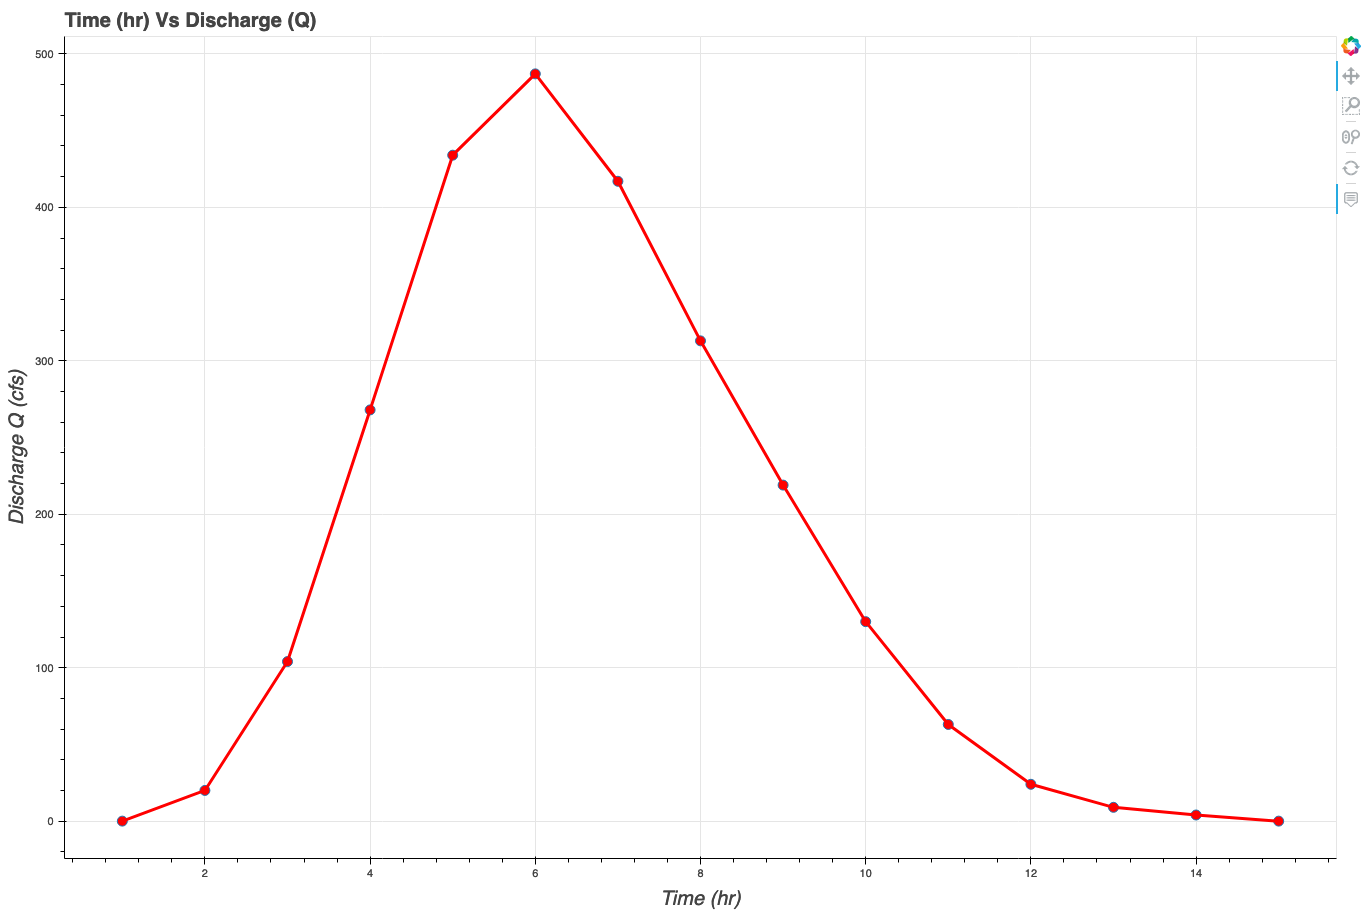

In [23]:
fig = initialize_fig(title = 'Time (hr) Vs Discharge (Q)',
                     x_axis_label = 'Time (hr)',
                     y_axis_label = 'Discharge Q (cfs)',
                     tooltips = [
                         ('time(hr)', '$x'),
                         ('discharge(cfs)'    , '$y'),
                     ],
                     plot_height = 300,
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'

fig.circle(df.hr_all, df.Qn, fill_color='red', size=10)
fig.line(df.hr_all, df.Qn, line_width=3, line_color='red')

bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/problem_2.png', height=200, width=300)
Image(f'{BASE_DIR}/problem_2.png')

### Question 3

#### For the above watershed in #1, the overland slope was calculated to be 1% and the hydraulic length is 6000ft. Use the SCS unit hydrograph method to develop a storm hydrograph. In this case it is know that the rainfall during each 15 min interval was 0.75 in, 1.5 in, 1.25 in, and 0.5 in.


In [24]:
# hydraulic length
l = 6000 # ft
# slope
m = 1 # percent
area = 150. # acres
area = area * (3.8611e-7 / 2.4711e-4) # miles-squared
d = 15 # min
area

0.2343753793856987

In [25]:
S # inches

0.814708002883922

In [26]:
# rainfalls
Ps = [0.75, 1.5, 1.25, 0.5]
Qs = [((P - 0.2 * S)**2) / (P + 0.8 * S) for P in Ps]
Qs # inches

[0.24585948398115126,
 0.8308174909466758,
 0.6213675677112516,
 0.09863837354012726]

In [27]:
# lag time
tL = (l**.8 * (S + 1.)**.7) / (1900. * m**.5) # hr
tL = tL * 60 # min
tL

50.47581940826938

In [28]:
# time to rise
TR = Tp = d / 2. + tL
TR # min

57.97581940826938

In [29]:
# base duration
B = 1.67 * TR
B # min

96.81961841180986

In [30]:
# total duration
T = TR + B
T # min

154.79543782007923

In [31]:
# peak flow
# TR in hr for cfs
qp = 484. * area * (TR / 60) # cfs
qp

109.61071099667977

In [32]:
# final peak flow
Qps = [round(Q * qp, 4) for Q in Qs]
Qps # cfs

[26.9488, 91.0665, 68.1085, 10.8118]

In [33]:
times = list(np.arange(0, 220, 15))
mins = [0, 15, 30, 45]
# times to peak
peak_times = [round(_min + TR, 4) for _min in mins]
print(f'peak_times: {peak_times}')
# total time
end_times = [round(_min + T, 4) for _min in mins]
print(f'end_times: {end_times}')
# all times
times = times + peak_times + end_times
times.sort()
print(times)

peak_times: [57.9758, 72.9758, 87.9758, 102.9758]
end_times: [154.7954, 169.7954, 184.7954, 199.7954]
[0, 15, 30, 45, 57.9758, 60, 72.9758, 75, 87.9758, 90, 102.9758, 105, 120, 135, 150, 154.7954, 165, 169.7954, 180, 184.7954, 195, 199.7954, 210]


In [34]:
def _two_step_linear_interpolate(index, fill_array):

    for i, val in enumerate(times):

        if i == index:
            fill_array[i] = 0

        if val == peak_times[index]:
            peak_index = i
            fill_array[i] = Qps[index]

            x0 = times[index]
            y0 = fill_array[index]
            x1 = times[peak_index]
            y1 = fill_array[peak_index]

            # interpolation
            for j in range(index + 1, i):
                val = y0 + (times[j] - x0) * (y1 - y0) / (x1 - x0)
                fill_array[j] = round(val, 4)

        if val == end_times[index]:
            fill_array[i] = 0

            x0 = times[peak_index]
            y0 = fill_array[peak_index]
            x1 = times[i]
            y1 = fill_array[i]

            # interpolation
            for j in range(peak_index + 1, i):
                val = y0 + (times[j] - x0) * (y1 - y0) / (x1 - x0)
                fill_array[j] = round(val, 4)
    
    return fill_array

In [35]:
# 0 min
index = 0

time_0 = np.empty(len(times))
time_0.fill(np.nan)

time_0 = _two_step_linear_interpolate(index, time_0)
print(time_0)


[ 0.      6.9724 13.9449 20.9173 26.9488 26.3854 22.7737 22.2103 18.5986
 18.0352 14.4235 13.8601  9.685   5.5099  1.3348  0.         nan     nan
     nan     nan     nan     nan     nan]


In [36]:
# 15 min
index = 1
time_15 = np.empty(len(times))
time_15.fill(np.nan)

time_15 = _two_step_linear_interpolate(index, time_15)
print(time_15)


[    nan  0.     23.5615 47.123  67.505  70.6845 91.0665 89.1626 76.9578
 75.0539 62.8491 60.9452 46.8365 32.7278 18.6191 14.1087  4.5105  0.
     nan     nan     nan     nan     nan]


In [37]:
# 30 min
index = 2
time_30 = np.empty(len(times))
time_30.fill(np.nan)

time_30 = _two_step_linear_interpolate(index, time_30)
print(time_30)

[    nan     nan  0.     17.6216 32.8653 35.2432 50.4869 52.8649 68.1085
 66.6846 57.5566 56.1327 45.5808 35.029  24.4771 21.1037 13.9252 10.5519
  3.3734  0.         nan     nan     nan]


In [38]:
# 45 min
index = 3
time_45 = np.empty(len(times))
time_45.fill(np.nan)

time_45 = _two_step_linear_interpolate(index, time_45)
print(time_45)

[    nan     nan     nan  0.      2.4198  2.7973  5.2172  5.5946  8.0145
  8.392  10.8118 10.5858  8.9107  7.2357  5.5606  5.0251  3.8856  3.3501
  2.2105  1.675   0.5355  0.         nan]


In [39]:
df = pd.DataFrame({'time(mins)': times, 'time_0': time_0, 'time_15': time_15, 'time_30': time_30, 'time_45': time_45})
df

,time(mins),time_0,time_15,time_30,time_45
0,0.0000,0.0000,NaN,NaN,NaN
1,15.0000,6.9724,0.0000,NaN,NaN
2,30.0000,13.9449,23.5615,0.0000,NaN
3,45.0000,20.9173,47.1230,17.6216,0.0000
4,57.9758,26.9488,67.5050,32.8653,2.4198
5,60.0000,26.3854,70.6845,35.2432,2.7973
6,72.9758,22.7737,91.0665,50.4869,5.2172
7,75.0000,22.2103,89.1626,52.8649,5.5946
8,87.9758,18.5986,76.9578,68.1085,8.0145
9,90.0000,18.0352,75.0539,66.6846,8.3920


In [40]:
df['total'] = df[['time_0', 'time_15', 'time_30', 'time_45']].sum(axis=1)
df

,time(mins),time_0,time_15,time_30,time_45,total
0,0.0000,0.0000,NaN,NaN,NaN,0.0000
1,15.0000,6.9724,0.0000,NaN,NaN,6.9724
2,30.0000,13.9449,23.5615,0.0000,NaN,37.5064
3,45.0000,20.9173,47.1230,17.6216,0.0000,85.6619
4,57.9758,26.9488,67.5050,32.8653,2.4198,129.7389
5,60.0000,26.3854,70.6845,35.2432,2.7973,135.1104
6,72.9758,22.7737,91.0665,50.4869,5.2172,169.5443
7,75.0000,22.2103,89.1626,52.8649,5.5946,169.8324
8,87.9758,18.5986,76.9578,68.1085,8.0145,171.6794
9,90.0000,18.0352,75.0539,66.6846,8.3920,168.1657


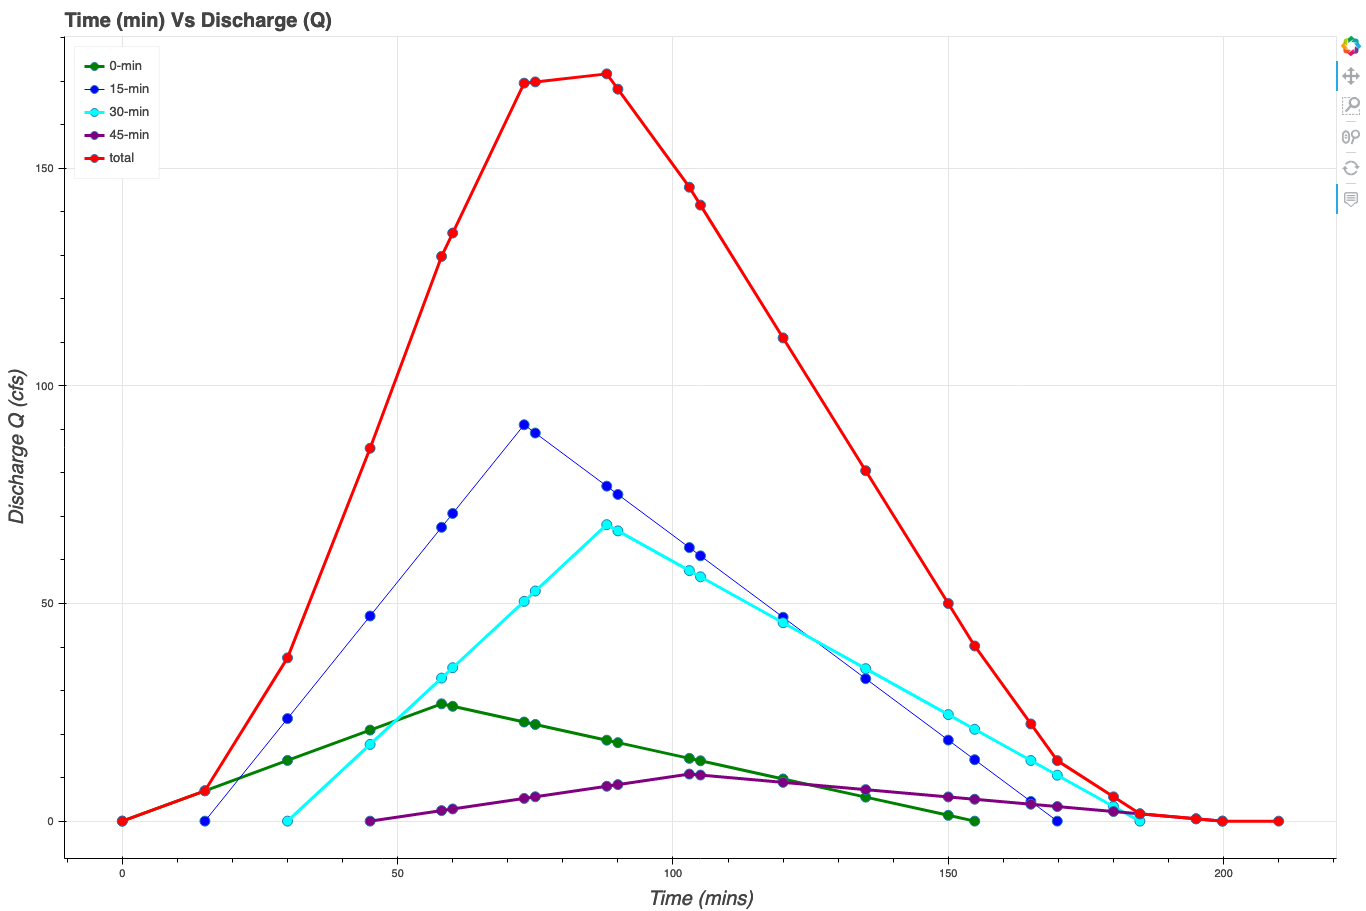

In [41]:
fig = initialize_fig(title = 'Time (min) Vs Discharge (Q)',
                     x_axis_label = 'Time (mins)',
                     y_axis_label = 'Discharge Q (cfs)',
                     tooltips = [
                         ('time(min)', '$x'),
                         ('discharge(cfs)'    , '$y'),
                     ],
                     plot_height = 300,
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'

fig.circle(df['time(mins)'], df.time_0, fill_color='green', size=10, legend_label='0-min')
fig.line(df['time(mins)'], df.time_0, line_width=3, line_color='green', legend_label='0-min')

fig.circle(df['time(mins)'], df.time_15, fill_color='blue', size=10, legend_label='15-min')
fig.line(df['time(mins)'], df.time_15, line_color='blue', legend_label='15-min')

fig.circle(df['time(mins)'], df.time_30, fill_color='cyan', size=10, legend_label='30-min')
fig.line(df['time(mins)'], df.time_30, line_width=3, line_color='cyan', legend_label='30-min')

fig.circle(df['time(mins)'], df.time_45, fill_color='purple', size=10, legend_label='45-min')
fig.line(df['time(mins)'], df.time_45, line_width=3, line_color='purple', legend_label='45-min')

fig.circle(df['time(mins)'], df.total, fill_color='red', size=10, legend_label='total')
fig.line(df['time(mins)'], df.total, line_width=3, line_color='red', legend_label='total')

fig.legend.location = 'top_left'
fig.legend.click_policy='hide'
bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/problem_3.png', height=200, width=300)
Image(f'{BASE_DIR}/problem_3.png')

### Question 4
#### Using the Muskingum-Cunge method, route the following inflow hydrograph 545 miles downstream. Use So = 0.0001, and the flow cross sectional area and width at a Q of 59,960 cfs is 5996 ft2 and 60 ft, respectively. $\Delta$t = 1 day.

| Date  | Inflow |
| ---   | ---    |
| 03-16 |  4260  |
| 03-17 |  7646  |
| 03-18 | 11167  |
| 03-19 | 16730  |
| 03-20 | 21590  |
| 03-21 | 20950  |
| 03-22 | 26570  |
| 03-23 | 46000  |
| 03-24 | 59960  |
| 03-25 | 57740  |
| 03-26 | 47890  |
| 03-27 | 34460  |
| 03-28 | 21660  |
| 03-29 | 34680  |
| 03-30 | 45180  |
| 03-31 | 49140  |
| 04-01 | 41290  |
| 04-02 | 33830  |
| 04-03 | 20510  |
| 04-04 | 14720  |
| 04-05 | 11436  |
| 04-06 |  9294  |
| 04-07 |  7831  |
| 04-08 |  6228  |
| 04-09 |  6083  |

In [42]:
# adding year for plotting purpose
Ts = ['2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25',
      '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04',
      '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09']
Qs = [4260, 7646, 11167, 16730, 21590, 20950, 26570, 46000, 59960, 57740, 47890, 34460, 21660, 34680, 45180, 49140,
      41290, 33830, 20510, 14720, 11436, 9294, 7831, 6228, 6083 ]

In [43]:
So = 0.0001

# cross-sectional area
Q_ref = 59960 # cfs
A_ref = 5996 # ft2
B = 60 # ft
Δt = 1. # day


ΔX = 545 # miles
ΔX = ΔX * (3.2808 / 6.2137e-4) # ft
ΔX

2877570.529636127

In [44]:
V = Q_ref / A_ref # ft/sec
V # ft/sec

10.0

In [45]:
# kinematic wave celerity
c = 5 / 3 * V # ft/sec
c

16.666666666666668

In [46]:
K = ΔX / c # sec
K = K / (60 * 60 * 24) # days
K = round(K) * 1.
K # days

2.0

In [47]:
max(Qs) / (2 * B * So)

4996666.666666667

In [48]:
X = (1/2) - (max(Qs) / (2 * B * So * c * ΔX ))
X

0.39581489075164034

In [49]:
denom = K * (1 - X) + 0.5 * Δt
denom

1.7083702184967193

In [50]:
K, X, Δt

(2.0, 0.39581489075164034, 1.0)

In [51]:
C0_num = K * X + 0.5 * Δt
C0 = C0_num / denom
C0

0.7560596453383802

In [52]:
C1_num = 0.5 * Δt - K * X
C1 = C1_num / denom
C1

-0.1707064302255868

In [53]:
C2_num = K * (1 - X) - 0.5 * Δt
C2 = C2_num / denom
C2

0.41464678488720663

In [54]:
# sanity check
C0 + C1 + C2

1.0

In [55]:
df = pd.DataFrame({'datetime': Ts, 'Q_inflow': Qs})
df['datetime'] =  pd.to_datetime(df['datetime'])
df.index = pd.to_datetime(df.datetime)
df = df.drop('datetime', axis=1)
df

,Q_inflow
datetime,
2018-03-16,4260
2018-03-17,7646
2018-03-18,11167
2018-03-19,16730
2018-03-20,21590
2018-03-21,20950
2018-03-22,26570
2018-03-23,46000
2018-03-24,59960


In [56]:
C0__Qj_n = list(df.Q_inflow * C0)
C0__Qj_n = [np.nan] + list(C0__Qj_n)
C0__Qj_n = C0__Qj_n[:-1]

In [57]:
df['C0__Qj_n'] = C0__Qj_n
df

,Q_inflow,C0__Qj_n
datetime,,
2018-03-16,4260,NaN
2018-03-17,7646,3220.814089
2018-03-18,11167,5780.832048
2018-03-19,16730,8442.918059
2018-03-20,21590,12648.877867
2018-03-21,20950,16323.327743
2018-03-22,26570,15839.449570
2018-03-23,46000,20088.504777
2018-03-24,59960,34778.743686


In [58]:
C1_Qj__n_1 = df.Q_inflow * C1
C1_Qj__n_1[0] = np.nan

In [59]:
df['C1_Qj__n_1'] = C1_Qj__n_1
df

,Q_inflow,C0__Qj_n,C1_Qj__n_1
datetime,,,
2018-03-16,4260,NaN,NaN
2018-03-17,7646,3220.814089,-1305.221366
2018-03-18,11167,5780.832048,-1906.278706
2018-03-19,16730,8442.918059,-2855.918578
2018-03-20,21590,12648.877867,-3685.551829
2018-03-21,20950,16323.327743,-3576.299713
2018-03-22,26570,15839.449570,-4535.669851
2018-03-23,46000,20088.504777,-7852.495790
2018-03-24,59960,34778.743686,-10235.557556


In [60]:
Q_outflow = []
for i in range(len(df.Q_inflow)):
    if i == 0:
        Q_total = list(df.Q_inflow.values)[0]
    else:
        Q_before = Q_outflow[-1]
        Q_part = C2 * Q_before
        Q_total = Q_part + C0__Qj_n[i] + C1_Qj__n_1[i]
    Q_outflow.append(Q_total)


In [61]:
df['Q_outflow'] = Q_outflow
df

,Q_inflow,C0__Qj_n,C1_Qj__n_1,Q_outflow
datetime,,,,
2018-03-16,4260,NaN,NaN,4260.000000
2018-03-17,7646,3220.814089,-1305.221366,3681.988027
2018-03-18,11167,5780.832048,-1906.278706,5401.277839
2018-03-19,16730,8442.918059,-2855.918578,7826.621972
2018-03-20,21590,12648.877867,-3685.551829,12208.609675
2018-03-21,20950,16323.327743,-3576.299713,17809.288779
2018-03-22,26570,15839.449570,-4535.669851,18688.344052
2018-03-23,46000,20088.504777,-7852.495790,19985.070762
2018-03-24,59960,34778.743686,-10235.557556,32829.931467


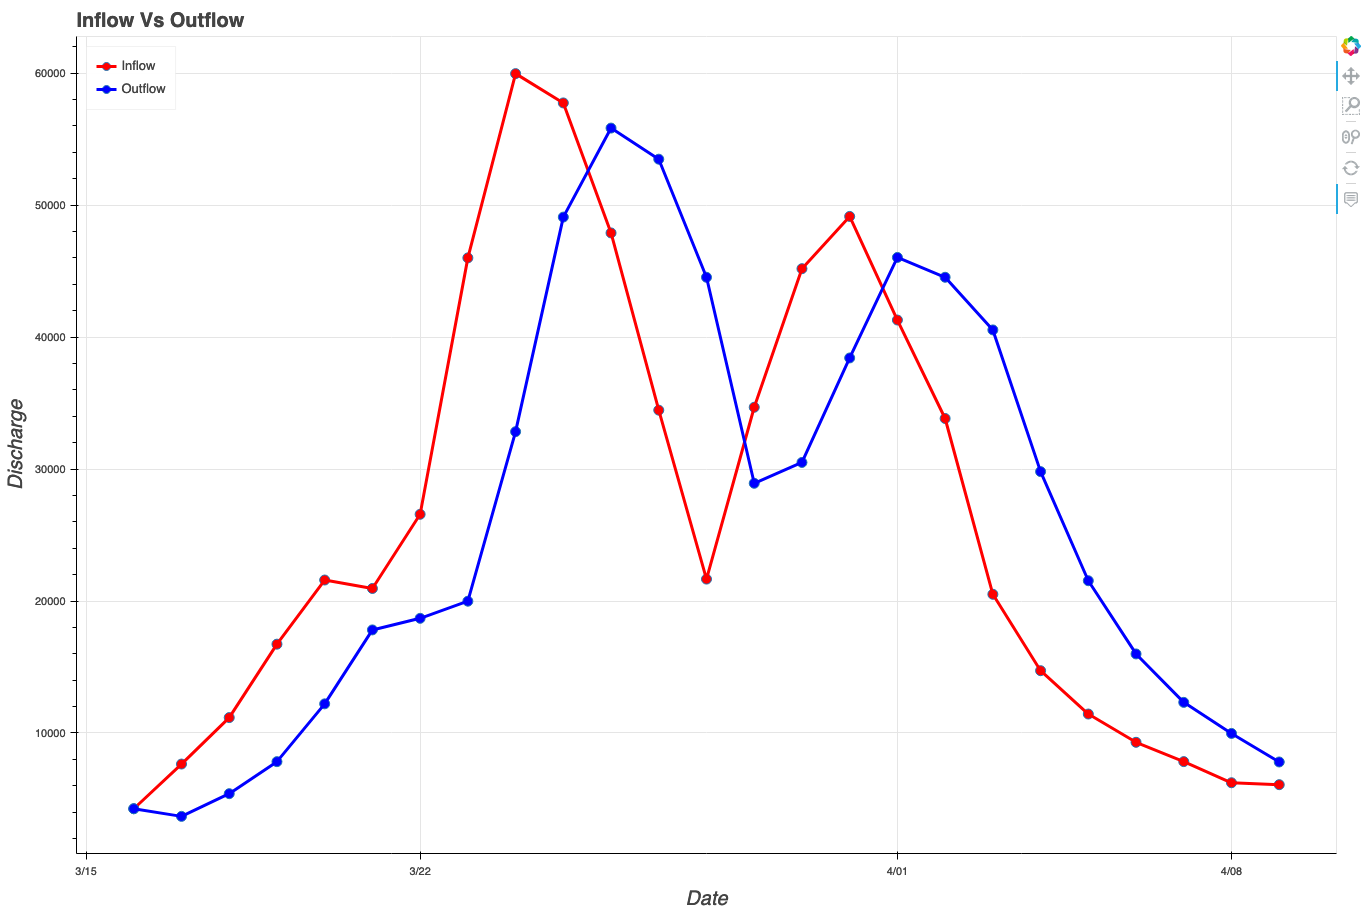

In [62]:
fig = initialize_fig(title = 'Inflow Vs Outflow',
                     x_axis_label = 'Date',
                     y_axis_label = 'Discharge',
                     tooltips = [
                         ('date',       '$x{%F}'),
                         ('discharge' , '$y'),
                     ],
                     x_axis_type = 'datetime',
                     plot_height = 300,
                     formatters = { '$x' : 'datetime' },
                    )

fig.title.text_font_size = '15pt'
fig.xaxis.axis_label_text_font_size = '15pt'
fig.yaxis.axis_label_text_font_size = '15pt'

fig.circle(df.index, df.Q_inflow, fill_color='red', size=10, legend_label='Inflow')
fig.line(df.index, df.Q_inflow, line_width=3, line_color='red', legend_label='Inflow')

fig.circle(df.index, df.Q_outflow, fill_color='blue', size=10, legend_label='Outflow')
fig.line(df.index, df.Q_outflow, line_width=3, line_color='blue', legend_label='Outflow')

fig.legend.location = 'top_left'
fig.legend.click_policy='hide'
bp.show(fig)

export_png(fig, filename=f'{BASE_DIR}/problem_4.png', height=200, width=300)
Image(f'{BASE_DIR}/problem_4.png')